### Spectroscopic Data Analysis
        Sean Keenan, PhD Physics
        Quantum Memories Group, Heriot-Watt University, Edinburgh
        2021

In [1]:
import spec_funcs as sf
import fit_funcs as ff

##### Set-up script
        Select input folder and polarisation

In [2]:
# change to gui at later date
# polarisations as written in file names
#polarisations = ["100", "110", "131", "86"]

# folder containing all the requisite subfolders and data - refrences included
path = "C:\\Users\\keena\Desktop\\0222_BB"

c_fact = 0.2

# mark energies / wavelengths of interest
woi = [594.24, 603.23, 604.24]

# save images 
save_fig = False

# reference names
refs = "ref", "reference", "R"

# file extension types
exts = (".csv", ".txt", ".CSV")
exceptions = ("notes", "setup", "ignore")

##### Import Raw Spectroscopy Data
        Load raw data from csv file (delimiter is not a problem) and sort into groups - polarisations -> reference / spectrum


In [3]:
folder_list, file_list = sf.dir_interogate(path, exts, exceptions)
path_names = sf.read_files(folder_list, file_list)
ref_names, data_names = sf.search_paths(path_names, refs)
polarisations = sf.find_polarisations(ref_names, tail=1)
ref_data = sf.data_extract(ref_names, polarisations)
data_sets = sf.data_extract(data_names, polarisations)
wave_sets, OD_sets = sf.OD_calc(ref_data, data_sets, correction=True, c_factor=c_fact)

c:\Users\keena\Documents\University\PhD\Code\Spectroscopy\spec_funcs.py:122: RuntimeWarning: divide by zero encountered in true_divide
  sec_ax = ax.secondary_xaxis('top', functions= (lambda x: 1e7 / x, lambda x: 1e7 / x))


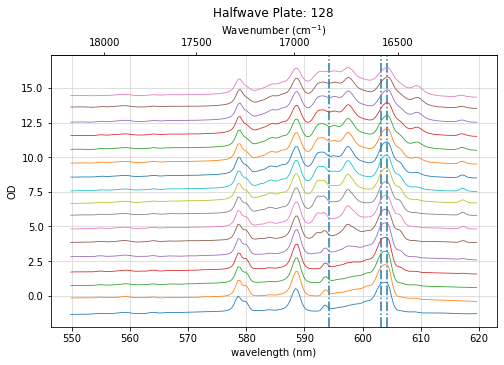

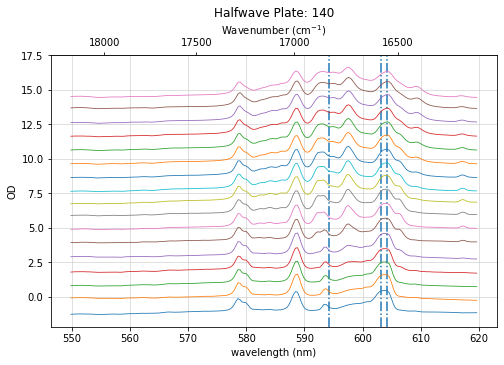

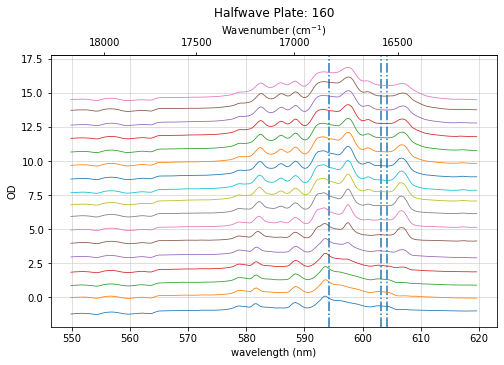

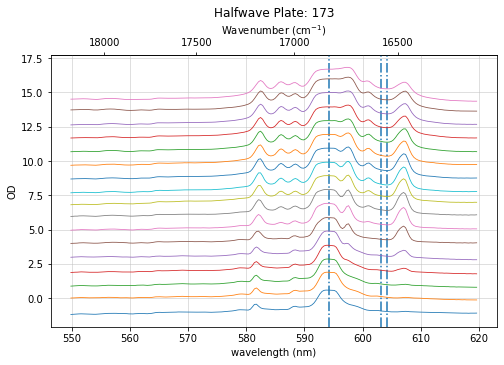

In [5]:
labels = 'wavelength (nm)', 'OD'
sf.plotter(wave_sets, OD_sets, keys=polarisations, axis_lbls=labels, lims=(550, 620), shifter=1, woi=woi, save=False, data_labels=folder_list)

##### Define ROI and fit to data
        Determine feature profile - Gaussian / Lorentzian and return confidence

In [ ]:
# roi bounds (wavelength)
roi_lower = 590
roi_upper = 610

# select to smooth data
smooth = True
sigma = 0.6

# modifiers for peak finding (prominence, distance between peaks)
prom_tol = 0.1
dist = 10

# array to identify indexes for roi
roi_waves = []
roi_ODs = []
peaks = []
smoothed = []
smoothed_peaks = []
for index, waves in enumerate(wave_sets):
    roi_wave_temp = []
    roi_OD_temp = []
    temp_peaks = []
    for index_2, wave in enumerate(waves):
        for idx, value in enumerate(wave):
            if value <= roi_lower:
                temp_start = idx
            if value <= roi_upper:
                temp_stop = idx
        roi_wave_temp.append(np.array(wave[temp_start:temp_stop]))
        roi_OD_temp.append(OD[index][index_2][temp_start:temp_stop])
        peak, _ = ss.find_peaks(roi_OD_temp[index_2], distance=dist, prominence=np.amax(roi_OD_temp[index_2]) * prom_tol)
        temp_peaks.append(peak)
        if smooth == True:
            smoothed_temp = []
            smoothed_peaks_temp = []
            smoothed_temp.append(nd.gaussian_filter(roi_OD_temp[index_2], sigma))
            smoothed_peaks_temp.append(ss.find_peaks(smoothed_temp[index_2], distance=dist, prominence=np.amax(smoothed_temp[index_2]) * prom_tol))
    roi_waves.append(roi_wave_temp)
    roi_ODs.append(roi_OD_temp)
    peaks.append(temp_peaks)
    smoothed.append(smoothed_temp)
    smoothed_peaks.append(smoothed_peaks_temp)

if smooth == True:
    gauss_ODs = [nd.gaussian_filter(x, sigma) for x in roi_ODs]

for idx_1, polarisation in enumerate(polarisations):

    fig_2, ax_2 = mp.subplots(figsize=(8, 5))
    ax_2.set_title(str('Half-Wave Plate: ' + str(polarisation)))
    ax_2.set(xlabel='Wavelength (nm)', ylabel='OD Normalised')
    sec_ax = ax_2.secondary_xaxis('top', functions= (lambda x: 1e7 / x, lambda x: 1e7 / x))
    sec_ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax_2.grid(True)
    ax_2.grid(True, color='silver', linewidth=0.5)
    
    for idx_2, data in enumerate(roi_waves[idx_1]):
        ax_2.plot(data, roi_ODs[idx_1][idx_2])
        ax_2.plot(data[peaks[idx_1][idx_2]], roi_ODs[idx_1][idx_2][peaks[idx_1][idx_2]], 'bx')
        if smooth == True:
            ax_2.plot(data, smoothed[idx_1][idx_2], '--r')
        print('peak locations for Half-Wave Plate: ' + str(polarisation), peaks[idx_1][idx_2])

In [ ]:
diff = np.diff(roi_ODs[4][0], n=1)
diff_2 = np.diff(roi_ODs[4][0], n=2)
diff_3 = np.diff(roi_ODs[4][0], n=3)

mp.plot(diff)
#mp.plot(diff_2)
#mp.plot(diff_3)
mp.plot(roi_ODs[4][0])

In [ ]:
x =np.linspace(-100, 100, 10000)
amp_g = 40
amp_l = 20
y_0 = 0
x_0g = 1
x_0l = -1
sigma = 15
gamma = 40
eta = 0.8

gauss = sf.gaussian(x, amp_g, y_0, x_0g, sigma)
lorentz = sf.lorentzian(x, amp_l, y_0, x_0l, gamma)
noise = np.random.normal(size=np.size(gauss))

voigt = sf.pseudo_voigt(x, y_0, amp_g, x_0g, sigma, amp_l, x_0l, gamma, eta) + noise

mp.plot(x, gauss, 'r', label='gauss')
mp.plot(x, lorentz, 'b', label='lorentz')
mp.plot(x, voigt, 'orange', alpha=0.5, label='voigt')
mp.legend()

In [ ]:
fit_g = sf.fitgauss(x, voigt)
fit_l = sf.fitlorentz(x, voigt)
fit_v = sf.fitgls(x, voigt)

mp.plot(x, sf.lorentzian(x, *fit_l[0]), '--b', label='lorentz fit')
mp.plot(x, sf.gaussian(x, *fit_g[0]), '--g', label='gauss fit')
mp.plot(x, sf.pseudo_voigt(x, *fit_v[0]), '--r', label='voigt fit')
mp.plot(x, voigt, color='orange', alpha=0.5, label='noisey voigt')
mp.legend()